In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from pandas_datareader import data as pdr
import yfinance as yf

In [4]:
# Define a function to download stock data
def get_stock_data(tickers, start_date, end_date):
    """
    Download historical stock data for the specified tickers and date range
    """
    stock_data = pdr.get_data_yahoo(tickers, start=start_date, end=end_date)['Adj Close']
    return stock_data

In [5]:
def portfolio_performance(weights, returns):
    """
    Calculate portfolio return and volatility
    """
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

In [6]:
# Define the negative Sharpe ratio (for minimization)
def negative_sharpe_ratio(weights, returns, risk_free_rate=0.02):
    """
    Calculate the negative Sharpe ratio for optimization (we minimize this)
    """
    p_return, p_volatility = portfolio_performance(weights, returns)
    return -(p_return - risk_free_rate) / p_volatility

In [7]:
def optimize_portfolio(returns, risk_free_rate=0.02, constraint_set=(0, 1)):
    """
    Find the optimal portfolio weights that maximize the Sharpe ratio
    
    Parameters:
    returns: DataFrame of asset returns
    risk_free_rate: Risk-free rate
    constraint_set: Tuple with min and max weight constraints
    
    Returns:
    Tuple of (optimal weights, optimal return, optimal volatility, optimal Sharpe ratio)
    """
    num_assets = len(returns.columns)
    args = (returns, risk_free_rate)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
    bounds = tuple(constraint_set for asset in range(num_assets))
    
    # Initial guess (equal weight)
    initial_guess = np.array(num_assets * [1. / num_assets])
    
    # Optimization
    optimal_result = sco.minimize(negative_sharpe_ratio, initial_guess, 
                                  args=args, method='SLSQP', 
                                  bounds=bounds, constraints=constraints)
    
    optimal_weights = optimal_result['x']
    optimal_return, optimal_volatility = portfolio_performance(optimal_weights, returns)
    optimal_sharpe = (optimal_return - risk_free_rate) / optimal_volatility
    
    return optimal_weights, optimal_return, optimal_volatility, optimal_sharpe

In [25]:
def plot_efficient_frontier(returns, risk_free_rate=0.02, num_portfolios=1000):
    """
    Plot the efficient frontier with the optimal portfolio highlighted
    """
    num_assets = len(returns.columns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    # Generate random portfolios
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        p_return, p_volatility = portfolio_performance(weights, returns)
        results[0, i] = p_volatility
        results[1, i] = p_return
        results[2, i] = (p_return - risk_free_rate) / p_volatility
    
    # Find and plot optimal portfolio
    optimal_weights, optimal_return, optimal_volatility, optimal_sharpe = optimize_portfolio(returns, risk_free_rate)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Sharpe ratio')
    plt.scatter(optimal_volatility, optimal_return, marker='*', color='r', s=500, label='Optimal portfolio')
    
    # Plot Capital Market Line
    plt.plot([0, optimal_volatility, 2*optimal_volatility], 
             [risk_free_rate, optimal_return, 2*optimal_return - risk_free_rate], 
             'r-', label='Capital Market Line')
    
    plt.title('Portfolio Optimization (Efficient Frontier)')
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    
    return plt, optimal_weights, optimal_return, optimal_volatility, optimal_sharpe


[*********************100%***********************]  5 of 5 completed


Optimal Portfolio Weights:
AAPL: 0.0000
MSFT: 0.0000
AMZN: 0.1568
BRK-A: 0.0000
TSLA: 0.0000
Expected Annual Return: 1.6022
Expected Annual Volatility: 0.4427
Expected Sharpe Ratio: 3.5741


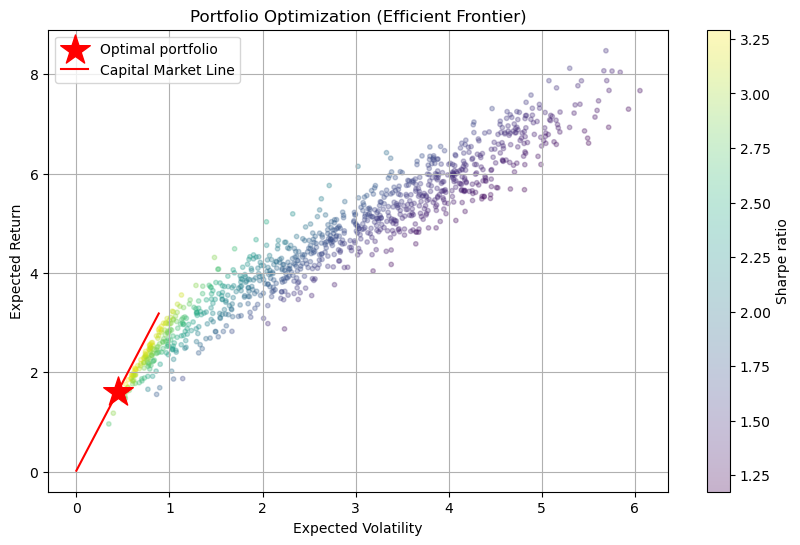

In [26]:
def main():
    # Define parameters
    tickers = ['AAPL', 'MSFT', 'AMZN', 'BRK-A', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-12-31'
    risk_free_rate = 0.02
    
    # Get data
    stock_data = yf.download(tickers, start_date, end_date)
    
    # Calculate returns
    returns = stock_data.pct_change().dropna()
    
    # Optimize portfolio
    plt, optimal_weights, optimal_return, optimal_volatility, optimal_sharpe = plot_efficient_frontier(returns, risk_free_rate)
    
    # Print results
    print("Optimal Portfolio Weights:")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {optimal_weights[i]:.4f}")
    print(f"Expected Annual Return: {optimal_return:.4f}")
    print(f"Expected Annual Volatility: {optimal_volatility:.4f}")
    print(f"Expected Sharpe Ratio: {optimal_sharpe:.4f}")
    
    plt.show()

if __name__ == "__main__":
    main()